# Simple Game of Corruption

## Overview

* Settle the Basic Model, the relevant constants and variables; 

* Build the Transition functions;

* Build the Reward Function;

* Find the optimal policy from one player given a greedy policy from the other player; and

* Use optimal policicies found and iterate until convergence.

In [2]:
import numpy as np
import quantecon as qe
import scipy.sparse as sparse
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP
%load_ext itikz
from datetime import datetime

### Constants

* Discrete time $t$;

* Two players $i$ =  $payer$ and $receiver$;

* Bribes are fixed $b$;

* Gains from corruption are $a$;

* Cost from perfoming the corruption favour $c$ ;

* Monetary Fines are $F$;

* $\delta$ is the time discount;

* Probability of detection is $\alpha$.

In [1]:
#Runing a computational excercize:

#Constants
b = 3
c = 1
a = 5
F = 7
alpha = 0.25
delta = 0.98
eta = 0.9
y0 = 0

It is possible to write the corruption in terms of payoffs $\pi$ and costs $\phi$ for players.

Or else, $\pi_{payer} = a$ and, $\pi_{receiver} = b$. Also, $\phi_{payer} = b$ and, $\phi_{receiver} = c$.


In [3]:
def pi(player):
    if player == 'payer':
        return a
    else:
        return b

    
def phi(player):
    if player == 'payer':
        return b
    else:
        return c    

### State and Actions:

This example is built using discrete time, decisions and states:

* Discrete (countable) states $\textbf{x}_{i,t}$;

* Discrete actions or decisions (controls)  $\textbf{d}_{i,t}$

\begin{equation*}
	\mathbf{d_t} \equiv
	\begin{bmatrix}
		d_{i,t} \\
		d_{j,t} 
	\end{bmatrix}\textrm{, and }
	\mathbf{x_t}\equiv
	\begin{bmatrix}
		w_{i,t}\\
		w_{j,t}\\
		s_t
	\end{bmatrix}
\end{equation*}


* $d_{i,t}$ is the decision from player $i$ to pay/receive a bribe in time $t$;

* $s_t$ is the state of the world at time $t$;

* $w_{i,t}$ is the wealth from player $i$ at time $t$. It goes from 0 to a maximum of $\overline{w}$;  and

* Lastly, $(s_t, w_{i,t}, w_{j,t} ) \in x_{t}$.



In [4]:
#maximun wealth from corruption:

w_bar = 30

#create the wealth statespace:
wi_space = np.arange(0,w_bar+1)
wj_space = np.arange(0,w_bar+1)

#creat the actionspace:

di_space = np.array([0,1])
dj_space = np.array([0,1])

# state of the world space

s_nc  = 0
s_cor = 1
s_det = 2

s_space = np.array([s_nc,s_cor,s_det])

### Laws of motion

$$\mathbf{x}_{t+1} = f ( \mathbf{x}_t , \mathbf{d}_t , \epsilon_{t+1} ; \theta ) $$

Where $\theta$ is a vector of parameters.

In this specific example we have:

$$w_{i,t+1} = w_{i,t} + \pi (a,b|s_{t+1}) $$
$$ s_{t+1} = f(\epsilon, s_t|d_t) $$

Where $\epsilon \sim Bernoulli ~ (\alpha)$

\* There is a living wage if walth ever gets to zero 

Let's impose that there are states of the world in which players can be. This, formulation helps when there are more states tied to the state of the world $s$.


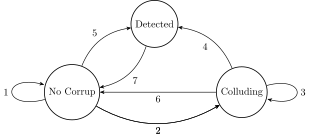

In [4]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}


\usetikzlibrary{decorations.pathreplacing,angles,quotes,calc,positioning,plotmarks}
\usetikzlibrary{shapes.geometric, arrows, automata,arrows,positioning,calc}
\tikzstyle{startstop} = [rectangle, rounded corners, minimum width=3cm, minimum height=1cm,text centered, draw=black]
\tikzstyle{io} = [trapezium, trapezium left angle=70, trapezium right angle=110, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{process} = [rectangle, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{decision} = [diamond, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{arrow} = [thick,->,>=stealth]

\begin{tikzpicture}[->, >=stealth', auto, semithick, node distance=2cm]
		\tikzstyle{every state}=[fill=white,draw=black,thick,text=black,scale=1]
		\node[state]    (A)                              		       {No Corrup};
		\node[state]    (B)[above right of= B]       at (1.5 ,1)	     	 {Detected};
		\node[state]    (C)[right of= B]        	at (4,0)	         {Colluding};
		\path
		(A) edge[loop left, left]	    	     node{1}   		           (A)
		(A) edge[bend right,below]    			 node{2}        			(C)
		(C) edge[loop right]    				 node{3}            		(C)
		(C) edge[bend right]                			 node{4}       	  (B)
		(A) edge[bend left]                			 node{5}      	  (B)
		(B) edge[bend left]                			 node{7}      	  (A)
		(A) edge[bend right,below]    			 node{2}        			(C)
		(C) edge[below]    			 node{6}        			(A)
                    ;
	\end{tikzpicture}
\end{document}

## Space transition rules:

Rules from $w$' from $w$:

$w$' must be feasible from $w$:

Rules for $w$' from $w$:

* #1 and #6 : $b_i$ = 0 or $b_j$ = 0 -> p = 1 ; 
 
* #2 and #3 : $b_i$ = 1 and $b_j$ = 1| s' = s_cor -> p = 1- $\alpha$;
 
* #4 and #5 : $b_i$ = 1 and $b_j$ = 1 | s' = s_det -> p = $\alpha$;
 
* #7: s = s_det | s' = s_det -> p = 1
 
 

In [5]:
#laws of motion

#wealth state transition Function (as function of all other states)
def w_prime(player,w,ui,uj,s_prime): 
    if ui == 1 and uj == 1: # Note that s_nc after ui and uj == 1  does not exist
        if s_prime == s_det:
            if w >= F + phi(player) - y0:
                return w + y0 - F - phi(player) #return from detection
            else:
                return 0
        elif s_prime == s_cor:
            if w <= w_bar - phi(player) - pi(player) - y0: 
                return w + y0 + pi(player) - phi(player) # return from corruption
            else: #if 
                return w_bar
    else:
        if w == w_bar:
            return w
        elif w <= phi(player):
            return w + y0 + 1 # living wage
        else:
            return w + y0
        
#State of the world transition Function (as function of all other states)

def s_prime(ui,uj):
    if ui == 0 or uj == 0: #rule 1 and 6
        return s_nc
    else:
        return (s_cor or s_det)

# The player i takes the action from j as given 
# first iteration is a greedy strategy

def dj(X,di):
    if X[2] == s_det:
        return 0
    else:
        if delta*((1-alpha)*pi('receiver') - alpha*F) > 0: # avoid workin with complex numbers
            if reward('receiver', X[1], di, 1) < delta* expected_return('receiver', X[1], di, 1):
                return 1
            else:
                return 0
        else:
            return 0


### Objective Function

$$ \max E_0 \sum^{\infty}_{t=0} \delta^t u( w_{t}) $$

For some reason, it is better to have money now than later (It's possible to set $\delta = 0$).

Therfore $u(.)$ is a CCRA function, where;

$$u(w) = \frac{w ^{(1-\eta)} - 1 } {1-\eta} $$

Where $\eta$ is the risk aversion parameter. Where $\eta > 0$ represents some degree of risk aversion.

In [6]:
#reward function:
def reward(player,wi,ui,uj):
#    return y - b*u #neutral risk aversion
    if wi - phi(player)*ui*uj >= 0:
        return (((wi - phi(player)*ui*uj)**(1-eta))-1)/(1-eta)
    else:
        return 0
eta = 0.9 # if eta =1 ln(y)

def expected_return(player,wi,ui,uj):
    if wi - phi(player)*ui*uj >= 0:
        return  ((((1-alpha)*pi(player) - alpha*F + wi )**(1-eta))-1)/(1-eta)
    else:
        return 0

### Dimension Reduction:

Instead of working with the entire space of controls and states (Sparce Matrices). One can reduce the number of state-acion space to only allowed movements in possible states, so the matrices decrease in dimension.

For instance in this exammple, the following rules apply for the states:

1 - It is not possible to pay a bribe if you are in the detected state of the world ;

2 - There are budget constraints. Or else, It is not possible to pay a bribe without funds;

3 - If agent succeded in bribing, state $w$ will be at least $\pi$:

4 - If agents are detected their wealth is going to be at most $\overline{w} - \phi - F$


PS: In the state transition it is necessary to impose limits to the transitions to maintain the system inside of the boundaries of feasible states. Or else, the sistem transiton cannot lead to state outside the state space. Here, we are excluding state and action pairs that would never be possible to achieve.

In [7]:
#Build the X and U space:

X = [] #set of feasible states corresponding to the action
D = [] #set of feasible actions corresponding to the space
XD = [] #creat the vector of the state action pair
X_indices = []

count = 0
index = 0
for i in wi_space:
    for j in wj_space:
        for k in s_space:
            for l in di_space:
                if k == s_det and (l == 1 or dj(np.asarray([i,j,k]),l) == 1): #rule 1
                    pass
                elif (i < phi('payer') and l == 1) or (j < phi('receiver') and dj(np.asarray([i,j,k]),l) == 1) : #rule2
                    pass
                elif k == s_cor and (i < pi('payer') + y0 or j < pi('receiver') + y0): #rule3
                    pass
                elif k == s_det and (i > w_bar - phi('payer') - F + y0 or j > w_bar - phi('receiver') - F + y0): #rule4
                    pass
                else:
                    X.append([i,j,k])
                    D.append(l)
                    XD.append([i,j,k,l])
                    #if the states are ordered, then the clauses bellow gives the X_indices
                    if index == 0:
                        X_indices.append(count)
                    elif X[index] == X[index-1]:
                        X_indices.append(count)
                    else:
                        count += 1
                        X_indices.append(count)
                    index += 1
#                         X = np.vstack([X,(i,j,k)])
#                         D = np.vstack([D,(l,m)])
#                         XD= np.vstack([XD ,(i,j,k,l,m)])
X = np.asarray(X) # converts integers to string
D = np.asarray(D)
XD = np.asarray(XD)

#Calculating the indices
#Indices are the maps unique actions and states

X_unique, indices = np.unique(X, axis=0, return_index=True) #new X space, only with unique feasible states

X_unique = X_unique[np.argsort(indices)] #return unique elements and maintain the original order

X_indices = np.asarray(X_indices)

D_unique, indices = np.unique(D, axis=0, return_index=True) #new X space, only with unique feasible states

D_unique = D_unique[np.argsort(indices)] #return unique elements and maintain the original order

D_indices = D

print('There are n = {} distict spaces-action pairs where players can be. Where m = {} are unique spaces'.format(len(X) , len(X_unique)))
print('Without the dimension reductions, we would be working with n = {} and m = {}'.format((w_bar*w_bar*len(di_space)*len(s_space)),(w_bar*w_bar*len(s_space)) ))



There are n = 3737 distict spaces-action pairs where players can be. Where m = 2169 are unique spaces
Without the dimension reductions, we would be working with n = 5400 and m = 2700


### The agent's problem:


$$ \max E_0 \sum^{\infty}_{t=0} \delta^t u( w_{t}) $$

s.t.

$$w_{i,t+1} = w_{i,t} + \pi (a,b|s_{t+1}) $$

$$ s_{t+1} = f(\epsilon, s_t|d_t) $$


It is possible to rewrite the agent's problem as a value function, such as:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{d}} \{ u(\mathbf{x}) + \delta E[V(\mathbf{x'})|\mathbf{x},\mathbf{d}]\}$$

This is called the Bellman Equation and it is quivallento to:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{d}} \{ R(\mathbf{x},\mathbf{d}) + \delta V(\mathbf{x'}) \Omega(\mathbf{x'},\mathbf{d},\mathbf{x})\}$$


This problem can be solved by iterating the matrix $\Omega$ through the reward function $R$.

Note that the controls $\mathbf{d}$ which solve the Bellman equation is a pair of decisions. This pair of decisions must hold at the optimum level.

So, to solve for the pair or decisions $\mathbf{d}$, first, we calculate the optimum policy for the payer $\sigma_{payer}$ using the receiver policy $\sigma_{receiver}$ as a greedy policy. Such that, 

 \begin{equation}
	\sigma(\mathbf{x}) \in \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ u(\mathbf{x}) + \delta \sum_{\mathbf{x}}  V^*(\mathbf{x'})\Omega(\mathbf{x'},\mathbf{u},\mathbf{x})\}
	\label{v4}
\end{equation}

The quantecom package DiscreteDP was used to calculate the strategies. 



### Generating the reward vector 

Each player has a reward vector $\textbf{R}$, such that:

\begin{equation*}
	\mathbf{R} \equiv
	\begin{bmatrix}
		R_{i} \\
		R_{j} 
	\end{bmatrix}
\end{equation*}

$R_i(x,d)$, of dimension $n$:

$$R_i(\textbf{x},\textbf{u}) =  \begin{bmatrix}
r_{i,0}(x_0,d_0)\\
\vdots \\
r_{i,n}(x_n,d_n) \end{bmatrix}$$

where $r_{i,j}(\textbf{x},\textbf{u})$ are the rewards from the state and control pair, where $i \in [payer,receiver]$ and $j \in [0,n]$.

In [8]:
# Calculating R for the payer:
R = []
for i in range(len(XD)):
    R.append(reward('payer', X[i][0], D[i] ,dj(X[i],D[i])  ) )


The transition matrix $\Omega(\textbf{x},\textbf{u},\textbf{x}')$, of dimension $n \times m $, can be calculated by:

$\Omega(\textbf{x},\textbf{u},) = \begin{bmatrix}
 \begin{bmatrix}
p(x_0'|x_0,d_0) \\
\vdots\\
p(x_0'|x_n,d_n) \end{bmatrix} \\
\vdots \\
\begin{bmatrix}
p(x_m'|x_0,d_0)\\
\vdots\\
p(x_m'|x_n,d_n)  \end{bmatrix} \end{bmatrix}$

In [9]:

Omega = np.zeros((len(X),len(X_unique)))
#finding the X_unique from the pair XD , dj:
for i in range(len(XD)):
    if s_prime(XD[i][3],dj(X[i],XD[i][3])) == s_nc or XD[i][2] == s_det: # rules 1, 6 and 7
        pos_2 = s_nc
        pos_0 = w_prime('payer',XD[i][0],XD[i][3],dj(X[i],XD[i][3]),s_nc)
        pos_1 = w_prime('receiver',XD[i][1],dj(X[i],XD[i][3]),XD[i][3],s_nc)
        loc_X_unique = np.array([pos_0, pos_1, pos_2])

        X_unique_prime = np.where(np.all(X_unique==loc_X_unique,axis=1))[0][0]
        
        Omega[i ,X_unique_prime] = 1
        
    else:
        #rules 4 and 5
        pos_2 = s_det
        pos_0 = w_prime('payer',XD[i][0],XD[i][3],dj(X[i],XD[i][3]),s_det)
        pos_1 = w_prime('receiver',XD[i][1],dj(X[i],XD[i][3]),XD[i][3],s_det)
        loc_X_unique = np.array([pos_0, pos_1, pos_2])

        X_unique_prime = np.where(np.all(X_unique==loc_X_unique,axis=1))[0][0]
        
        Omega[i ,X_unique_prime] = alpha
        
        #rules 2 and 3
        pos_2 = s_cor
        pos_0 = w_prime('payer',XD[i][0],XD[i][3],dj(X[i],XD[i][3]),s_cor)
        pos_1 = w_prime('receiver',XD[i][1],dj(X[i],XD[0][3]),XD[i][3],s_cor)
        loc_X_unique = np.array([pos_0, pos_1, pos_2])
        
        X_unique_prime = np.where(np.all(X_unique==loc_X_unique,axis=1))[0][0]
        
        Omega[i ,X_unique_prime] = 1 - alpha
        


We can check if the Omega matrix is ther correct transition matrix if the all rows sum up to 1.

In [10]:

test = []
fails = []
for i in range(len(Omega)):
    test.append(Omega[i].sum())
    if round(Omega[i].sum(),4) != 1:
        fails.append(i)
if len(fails) == 0:
    print('sucess: Omega shape (n X  m) ->', Omega.shape)
else:
    print('failed at the dimention(s) ->',fails)
    print(len(fails))

sucess: Omega shape (n X  m) -> (3737, 2169)


More specically. Each positively populated value in $\Omega$ represents the probability of transiting from that state-action pair $(x,d)\in n$ to the future state $x' \in m$. 

Or else:

In [11]:
#Use this cel to check any transition

teste = 234

print('From the pair state-action XD :',XD[teste])

for i in range(len(Omega[1])):
    if Omega[teste][i] !=0:
        print('Omega item', i, 'computed the probability of transition of', Omega[teste][i], 'that leads to the state : ', X_unique[i])

From the pair state-action XD : [ 3 26  0  1]
Omega item 36 computed the probability of transition of 0.25 that leads to the state :  [ 0 18  2]
Omega item 340 computed the probability of transition of 0.75 that leads to the state :  [ 5 26  1]


In [12]:
#creat the QE instance for solution 
ddp =qe.markov.DiscreteDP(R, Omega, delta, X_indices, D_indices)

In [13]:
results = ddp.solve(method='policy_iteration',max_iter=10000)

In [14]:
stationary = results.mc.stationary_distributions

#Stationary equilibrium
for i in range(len(stationary[0])):
    if stationary[0,i] != 0:
        print(round(stationary[0,i],4), X_unique[i])
        
#how to make it a zero summ game?

1.0 [10  8  0]


## Outer Algorithm to find Markovian Perfect Equilibrium

1. Solve i's dynamic programming problem when j plays a greedy strategy as given;

2. Use the optmal policy ($\sigma_i$) from i to calculate j's optimal policy ($\sigma_j$); and

3. Compare the policies $|| \sigma_i - \sigma_j||$, if they are equal stop, otherwise go to step 2 alternating players. 

In other words, when players have no incentive to change their strategies given the other player's best responses, it is a Markov Perfect Equilibrium.







For the Outer Algo, we create a class that computes all the steps above.
If we do not pass a policy $\sigma$, the class returns the $R$ and $\Omega$ matrices from a greedy 'other player' policy (as well as the state and action indices (X_indices and D_indices).
However, if a policy $\sigma$ is passed, than the best policy from 'other player' is calculated based in the policy.

In [15]:
class Matrices_Maker():

    def __init__(self, sigma = [], X_loc = [], player = 'payer', b = 3, c = 1, a = 5, F = 7, alpha = 0.25 , delta = 0.98 , y0 = 0, w_bar = 30 , eta = 0.9):
        """
        Set up an instance to run the Quantecon routine of discrete dynamic programing.
        
        """

        
        self.sigma, self.X_loc, self.player, self.b,self.c,self.a,self.F,self.alpha,self.delta,self.y0,self.w_bar,self.eta = sigma, X_loc, player,b,c,a,F,alpha,delta,y0,w_bar,eta
        
        self.start_time = datetime.now()
        
        if self.player == 'payer':
            self.otherplayer = 'receiver'
        else:
            self.otherplayer = 'payer'
        

        # #Constants:
        # b bribe
        # c cost from bribe
        # a advantage from corruption
        # F Fine
        # alpha Probability of conviction
        # delta Time discount
        # y0 Non financial income
        # w_bar Maximum wealrh from corruption

        # States and Action Spaces: 
        
        # #create the wealth statespace:
        self.wi_space = np.arange(0,self.w_bar+1)
        self.wj_space = np.arange(0,self.w_bar+1)

        # #creat the actionspace:

        self.di_space = np.array([0,1])
        self.dj_space = np.array([0,1])

        # # state of the world space

        self.s_nc  = s_nc
        self.s_cor = s_cor
        self.s_det = s_det


        self.s_space = np.array([self.s_nc,self.s_cor,self.s_det])        
        
        #Build the X and D space:

        self.X = [] #set of feasible states corresponding to the action
        self.D = [] #set of feasible actions corresponding to the space
        self.XD = [] #creat the vector of the state action pair
        self.X_indices = [] #Vector of indices from unique states in X
        #self.X_unique = []# Vector with unique elements of X
        
        self.count = 0
        self.index = 0
        for i in self.wi_space:
            for j in self.wj_space:
                for k in self.s_space:
                    for l in self.di_space:
                        if k == s_det and (l == 1 or self.dj(np.asarray([i,j,k]),l) == 1): #rule 1
                            pass
                        elif (i < self.phi('payer') and l == 1) or (j < self.phi('receiver') and self.dj(np.asarray([i,j,k]),l) == 1) : #rule2
                            pass
                        elif k == s_cor and (i < self.pi('payer') + self.y0 or j < self.pi('receiver') + self.y0): #rule3
                            pass
                        elif k == s_det and (i > self.w_bar - self.phi('payer') - self.F + self.y0  or j > self.w_bar - self.phi('receiver') - self.F + self.y0): #rule4
                            pass
                        else:
                            self.X.append([i,j,k])
                            self.D.append(l)
                            self.XD.append([i,j,k,l])
                            #if the states are ordered, then the clauses bellow gives the X_indices
                            if self.index == 0:
                                self.X_indices.append(self.count)
                            elif self.X[self.index] == self.X[self.index-1]:
                                self.X_indices.append(self.count)
                            else:
                                self.count += 1
                                self.X_indices.append(self.count)
                            self.index += 1


        #                         X = np.vstack([X,(i,j,k)])
        #                         D = np.vstack([D,(l,m)])
        #                         XD= np.vstack([XD ,(i,j,k,l,m)])
        self.X = np.asarray(self.X) # converts integers to string
        self.D = np.asarray(self.D)
        self.XD = np.asarray(self.XD)
        

        
        #Calculating the indexes #Calculating the indices
        #Indices are the maps unique actions and states

        self.X_unique, self.indices = np.unique(self.X, axis=0, return_index=True) #new X space, only with unique feasible states

        self.X_unique = self.X_unique[np.argsort(self.indices)] #return unique elements and maintain the original order

        self.X_indices = np.asarray(self.X_indices)

        self.D_unique, self.indices = np.unique(self.D, axis=0, return_index=True) #new X space, only with unique feasible states

        self.D_unique = self.D_unique[np.argsort(self.indices)] #return unique elements and maintain the original order

        self.D_indices = self.D
 
        #Calculating ther reward vector:
        if self.player == 'payer':
            self.R = []
            for i in range(len(self.XD)):
                self.R.append(self.reward(self.player, self.X[i][0], self.D[i] ,self.dj(self.X[i],self.D[i])  ) )
        else:
            self.R = []
            for i in range(len(self.XD)):
                self.R.append(self.reward(self.player, self.X[i][1], self.D[i] ,self.dj(self.X[i],self.D[i])  ) )
        
        #Calculating Omega Matrix
        self.Omega = np.zeros((len(self.X),len(self.X_unique))) #this omega is calculated using the dj as given

        #finding the X_unique prime from the pair XD , dj:
        for i in range(len(self.XD)):
            if self.s_prime(self.XD[i][3],self.dj(self.X[i],self.XD[i][3])) == self.s_nc or self.XD[i][2] == self.s_det: # rules 1, 6 and 7
                self.pos_2 = self.s_nc
                self.pos_0 = self.w_prime('payer',self.XD[i][0],self.XD[i][3],self.dj(self.X[i],self.XD[i][3]),self.s_nc)
                self.pos_1 = self.w_prime('receiver',self.XD[i][1],self.dj(self.X[i],self.XD[i][3]),self.XD[i][3],self.s_nc)
                self.loc_X_unique = np.array([self.pos_0, self.pos_1, self.pos_2])

                self.X_unique_prime = np.where(np.all(self.X_unique==self.loc_X_unique,axis=1))[0][0]

                self.Omega[i ,self.X_unique_prime] = 1

            else:
                #rules 4 and 5
                self.pos_2 = self.s_det
                self.pos_0 = self.w_prime('payer',self.XD[i][0],self.XD[i][3],self.dj(self.X[i],self.XD[i][3]),self.s_det)
                self.pos_1 = self.w_prime('receiver',self.XD[i][1],self.dj(self.X[i],self.XD[i][3]),self.XD[i][3],self.s_det)
                self.loc_X_unique = np.array([self.pos_0, self.pos_1, self.pos_2])

                self.X_unique_prime = np.where(np.all(self.X_unique==self.loc_X_unique,axis=1))[0][0]

                self.Omega[i ,self.X_unique_prime] = self.alpha

                #rules 2 and 3
                self.pos_2 = self.s_cor
                self.pos_0 = self.w_prime('payer',self.XD[i][0],self.XD[i][3],dj(self.X[i],self.XD[i][3]),self.s_cor)
                self.pos_1 = self.w_prime('receiver',self.XD[i][1],self.dj(self.X[i],self.XD[0][3]),self.XD[i][3],self.s_cor)
                self.loc_X_unique = np.array([self.pos_0, self.pos_1, self.pos_2])

                self.X_unique_prime = np.where(np.all(self.X_unique==self.loc_X_unique,axis=1))[0][0]

                self.Omega[i ,self.X_unique_prime] = 1 - self.alpha



        
        

        self.end_time = datetime.now()
        print('Duration: {}'.format(self.end_time - self.start_time))
        ############################################################################
        ######################## FUNCTIONS #########################################
        ############################################################################
        
    
        
    def pi(self, player):
        if player == 'payer':
            return self.a
        else:
            return self.b


    def phi(self, player):
        if player == 'payer':
            return self.b
        else:
            return self.c    


    #laws of motion

    #wealth state transition Function (as function of all other states)
    def w_prime(self, player,w,ui,uj,s_prime): 
        if ui == 1 and uj == 1: # Note that s_nc after ui and uj == 1  does not exist
            if s_prime == s_det:
                if w >= self.F + self.phi(player) - self.y0:
                    return w + self.y0 - self.F - self.phi(player) #return from detectiono
                else:
                    return 0
            elif s_prime == s_cor:
                if w <= self.w_bar - self.phi(player) - self.pi(player) - self.y0: 
                    return w + self.y0 + self.pi(player) - self.phi(player) # return from corruption
                else: #if 
                    return self.w_bar
        else:
            if w == self.w_bar:
                return w
            elif w <= self.phi(player):
                return w + self.y0 + 1 # living wage # just enough to gather the funds to enter in corruption
            else:
                return w + self.y0

    #State of the world transition Function (as function of all other states)

    def s_prime(self, ui,uj):
        if ui == 0 or uj == 0:
            return self.s_nc
        else:
            return (self.s_cor or self.s_det)

    # The player i takes the action from j as given 
    # first iteration is a greedy strategy

    def dj(self, X,di):
        if X[2] == self.s_det:
            return 0
        elif (len(self.sigma)>0) and (X.tolist() in self.X_loc.tolist()):
            return self.sigma[np.where((self.X_loc == (X)).all(axis=1))][0] # dj from sigma mapping. It extracts the index from a row in X and
        else:
            if self.player == 'payer':
                if self.delta*((1-self.alpha)*self.pi(self.otherplayer) - self.alpha*self.F) > 0: # avoid workin with complex numbers
                    if self.reward(self.otherplayer, X[1], di, 1) < self.delta* self.expected_return(self.otherplayer, X[1], di, 1):
                        return 1
                    else:
                        return 0
                else:
                    return 0
            else:
                if self.delta*((1-self.alpha)*self.pi(self.otherplayer) - self.alpha*self.F) > 0: # avoid workin with complex numbers
                    if self.reward(self.otherplayer, X[0], 1, di) < self.delta* self.expected_return(self.otherplayer, X[0], 1 , di):
                        return 1
                    else:
                        return 0
                else:
                    return 0

    #reward function:
    def reward(self,player , wi, ui, uj):
    #    return y - b*u #neutral risk aversion
        if wi - self.phi(player)*ui*uj > 0:
            return (((wi - self.phi(player)*ui*uj)**(1-self.eta))-1)/(1-self.eta) #CRRA function 
        else:
            return 0
    #expected return function:
    def expected_return(self, player,wi,ui,uj):
        if wi - self.phi(player)*ui*uj > 0:
            return  ((((1-self.alpha)*self.pi(player) - self.alpha*self.F + wi )**(1-self.eta))-1)/(1-self.eta)
        else:
            return 0

    

Now, it is possible to iterate the policies from a greedy policy up to the point where agents do not want to change their strategies:

In [16]:
payer_sigma = np.zeros(len(results.sigma))
next_player = 'receiver'
count = 0
while not np.array_equal(results.sigma, payer_sigma): #iterates until payer_sigma is equal to its last decision policy
    player = next_player
    instance = Matrices_Maker(results.sigma, X_loc = X_unique, player = player,c = 1, b=3 , a=5 , F=7 , w_bar = 30)
    ddp =qe.markov.DiscreteDP(instance.R, instance.Omega, instance.delta, instance.X_indices, instance.D_indices)
    results = ddp.solve(method='policy_iteration')
    count += 1
    X_unique = instance.X_unique
    if player == 'payer':
        next_player = 'receiver'
        payer_sigma = results.sigma
    else:
        next_player = 'payer'  
else:
    print('Success after {} iterations'.format(count))

Duration: 0:00:06.027914
Duration: 0:00:05.485355
Success after 2 iterations


In [20]:
instance = Matrices_Maker( X_loc = X_unique, player = 'payer',c = 1, b=3 , a=5 , F=7 , w_bar = 30)
ddp =qe.markov.DiscreteDP(instance.R, instance.Omega, instance.delta, instance.X_indices, instance.D_indices)
results = ddp.solve(method='policy_iteration')
#Stationary equilibrium
for i in range(len(stationary[0])):
    if stationary[0,i] != 0:
        print(round(stationary[0,i],4), instance.X_unique[i])
        
#how to make it a zero summ game?

Duration: 0:00:00.674196
1.0 [10  7  0]


# Conclusion

* As it was supposed to happen, the players pay bribes untill that their utility from current wealth is lower than the expected walth gained from corrupion.

* After this, they stop colluding at their wealth level.
